# **[IntoAI] WEEK8 : NeuralNetwork**

### **0. 기본 환경 세팅**

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### **1. 퍼셉트론**

**노트**: 사이킷런 향후 버전에서 `max_iter`와 `tol` 매개변수의 기본값이 바뀌기 때문에 경고를 피하기 위해 명시적으로 지정합니다.

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [ ]:
y_pred

array([1])

그림 저장: perceptron_iris_plot


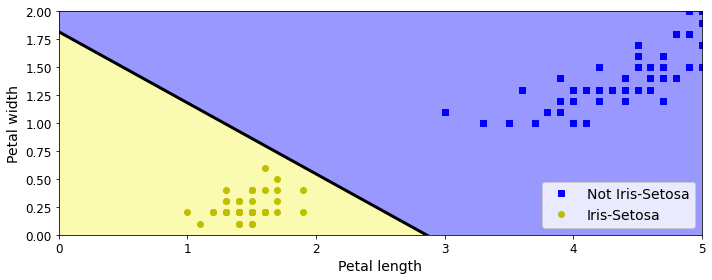

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

### **2. 활성화 함수**

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

그림 저장: activation_functions_plot


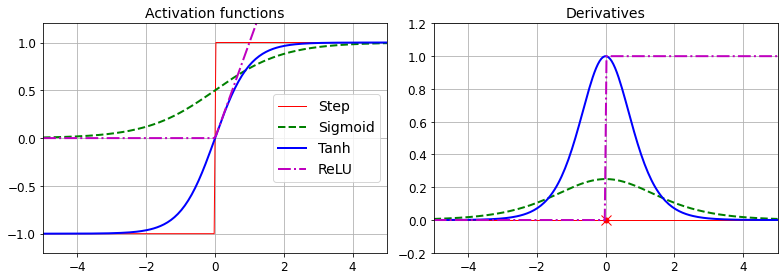

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

### **3. Neural Network**

In [ ]:
import keras
from sklearn.datasets import fetch_openml

MNIST Dataset 분류 : 흑백 손글씨 숫자 이미지(28x28 픽셀)를 10개의 범주(0에서 9까지)로 분류

MNIST 데이터셋은 넘파이 배열 형태로 케라스에 이미 포함되어 있습니다:

In [ ]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images`와 `train_labels`가 모델이 학습해야 할 훈련 세트를 구성합니다. 모델은 `test_images`와 `test_labels`로 구성된 테스트 세트에서 테스트될 것입니다. 이미지는 넘파이 배열로 인코딩되어 있고 레이블은 0에서부터 9까지의 숫자 배열입니다. 이미지와 레이블은 일대일 관계를 가집니다.

훈련 데이터를 살펴보겠습니다:

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

In [ ]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

다음은 테스트 데이터입니다:

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
len(test_labels)

10000

In [ ]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

다섯 번째 샘플을 맷플롯립 라이브러리를 사용해 확인해 보겠습니다.

In [ ]:
import matplotlib.pyplot as plt

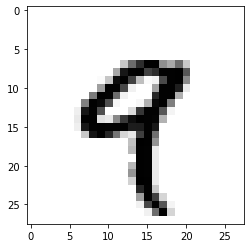

In [ ]:
digit = train_images[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

작업 순서는 다음과 같습니다. 먼저 훈련 데이터 `train_images`와 `train_labels`를 네트워크에 주입합니다. 그러면 네트워크는 이미지와 레이블을 연관시킬 수 있도록 학습됩니다. 마지막으로 `test_images`에 대한 예측을 네트워크에게 요청합니다. 그리고 이 예측이 `test_labels`와 맞는지 확인할 것입니다.

신경망을 만들어 보겠습니다. 여기에서도 다음 코드를 완전히 이해하지 않아도 괜찮습니다.

In [ ]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

신경망의 핵심 구성 요소는 일종의 데이터 처리 필터라고 생각할 수 있는 층입니다. 어떤 데이터가 들어가면 더 유용한 형태로 출력됩니다. 조금 더 구체적으로 층은 주어진 문제에 더 의미 있는 표현을 입력된 데이터로부터 추출합니다. 대부분의 딥러닝은 간단한 층을 연결하여 구성되어 있고, 점진적으로 데이터를 정제하는 형태를 띠고 있습니다. 딥러닝 모델은 데이터 정제 필터(층)가 연속되어 있는 데이터 프로세싱을 위한 여과기와 같습니다.

이 예에서는 조밀하게 연결된 (또는 완전 연결된) 신경망 층인 `Dense` 층 2개가 연속되어 있습니다. 두 번째 (즉, 마지막) 층은 10개의 확률 점수가 들어 있는 배열(모두 더하면 1입니다)을 반환하는 소프트맥스 층입니다. 각 점수는 현재 숫자 이미지가 10개의 숫자 클래스 중 하나에 속할 확률입니다.

신경망이 훈련 준비를 마치기 위해서 컴파일 단계에 포함될 세 가지가 더 필요합니다:

* 손실 함수 : 훈련 데이터에서 신경망의 성능을 측정하는 방법으로 네트워크가 옳은 방향으로 학습될 수 있도록 도와 줍니다.
* 옵티마이저: 입력된 데이터와 손실 함수를 기반으로 네트워크를 업데이트하는 메커니즘입니다.
* 훈련과 테스트 과정을 모니터링할 지표 : 여기에서는 정확도(정확히 분류된 이미지의 비율)만 고려하겠습니다.


In [ ]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

훈련을 시작하기 전에 데이터를 네트워크에 맞는 크기로 바꾸고 모든 값을 0과 1 사이로 스케일을 조정합니다. 예를 들어, 앞서 우리의 훈련 이미지는 `[0, 255]` 사이의 값인 `uint8` 타입의 `(60000, 28, 28)` 크기를 가진 배열로 저장되어 있습니다. 이 데이터를 0과 1 사이의 값을 가지는 `float32` 타입의 `(60000, 28 * 28)` 크기의 배열로 바꿉니다.

In [ ]:
train_images[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
train_images[4]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

또한, 레이블을 범주형으로 인코딩해야 합니다.

In [ ]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

이제 신경망을 훈련시킬 준비가 되었습니다. 케라스에서는 `fit` 메서드를 호출하여 훈련 데이터에 모델을 학습시킵니다:

In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.2577 - accuracy: 0.9246
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.1030 - accuracy: 0.9696
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0683 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0503 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0375 - accuracy: 0.9881


훈련하는 동안 두 개의 정보가 출력됩니다. 훈련 데이터에 대한 네트워크의 손실과 정확도입니다.

훈련 데이터에 대해 0.989(98.9%)의 정확도를 금방 달성합니다. 이제 테스트 세트에서도 모델이 잘 작동하는지 확인해 보겠습니다:

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0654 - accuracy: 0.9799


In [ ]:
print('test_acc:', test_acc)

test_acc: 0.9799000024795532


테스트 세트의 정확도는 97.8%로 나왔습니다. 훈련 세트 정확도보다는 약간 낮습니다. 훈련 정확도와 테스트 정확도 사이의 차이는 과대적합 때문입니다. 이는 머신 러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 경향을 말합니다. 과대적합은 3장에서 자세하게 논의하겠습니다.

이것으로 첫 번째 예제가 마무리되었습니다. 20줄 미만의 파이썬 코드로 손글씨 숫자를 분류하는 신경망을 만들고 훈련시켰습니다. 다음 장에서 여기서 보았던 코드 하나하나를 상세하게 설명하고 이들이 의미하는 바를 명확하게 설명하겠습니다. 이제 텐서, 신경망에 주입하는 데이터의 저장 형태, 층을 만들어주는 텐서 연산, 신경망을 훈련 샘플로부터 학습시키는 경사 하강법에 대해 알아보겠습니다.